<a href="https://colab.research.google.com/github/sergiynesterenko90/feranec/blob/main/notebooks/hexapod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training in Brax

Once an environment is created in brax, we can quickly train it using brax's built-in training algorithms. Let's try it out!

In [1]:
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

In [2]:
from etils import epath
path = epath.resource_path('brax') / 'envs/assets/ant.xml'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
ant_xml = """
<mujoco model="ant">
  <compiler angle="degree" coordinate="local" inertiafromgeom="true" settotalmass="100"/>
  <option timestep="0.01" iterations="4" />
  <custom>
    <!-- brax custom params -->
    <numeric data="0.0 0.0 0.55 1.0 0.0 0.0 0.0 0.0 1.0 0.0 -1.0 0.0 -1.0 0.0 1.0 0.55 0.0 0.0 0.0" name="init_qpos"/>
    <numeric data="1000" name="constraint_limit_stiffness"/>
    <numeric data="4000" name="constraint_stiffness"/>
    <numeric data="10" name="constraint_ang_damping"/>
    <numeric data="20" name="constraint_vel_damping"/>
    <numeric data="0.5" name="joint_scale_pos"/>
    <numeric data="0.2" name="joint_scale_ang"/>
    <numeric data="0.0" name="ang_damping"/>
    <numeric data="1" name="spring_mass_scale"/>
    <numeric data="1" name="spring_inertia_scale"/>
    <numeric data="15" name="solver_maxls"/>
  </custom>
  <default>
    <joint armature="1" damping="1" limited="true"/>
    <geom contype="0" conaffinity="0" condim="3" density="5.0" friction="1 0.5 0.5"/>
  </default>
  <asset>
    <texture builtin="gradient" height="100" rgb1="1 1 1" rgb2="0 0 0" type="skybox" width="100"/>
    <texture builtin="flat" height="1278" mark="cross" markrgb="1 1 1" name="texgeom" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
    <texture builtin="checker" height="100" name="texplane" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d" width="100"/>
    <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
    <material name="geom" texture="texgeom" texuniform="true"/>
  </asset>
  <worldbody>
    <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
    <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" size="40 40 40" type="plane"/>
    <body name="torso" pos="0 0 0.75">
      <camera name="track" mode="trackcom" pos="0 -3 0.3" xyaxes="1 0 0 0 0 1"/>
      <geom name="torso_geom" pos="0 0 0" size="0.25" type="sphere" mass="10"/>
      <joint armature="0" damping="0" limited="false" margin="0.01" name="root" pos="0 0 0" type="free"/>

      <body name="front_left_leg" pos="0 0 0">
        <geom fromto="0.0 0.0 0.0 0.4 0.4 0.0" name="aux_1_geom" size="0.08" type="capsule"/>
        <body name="aux_1" pos="0.4 0.4 0">
          <joint axis="0 0 1" name="hip_1" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.2 0.2 0.0" name="left_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.2 0.2 0">
            <joint axis="-1 1 0" name="ankle_1" pos="0.0 0.0 0.0" range="30 70" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.4 0.4 0.0" name="left_ankle_geom" size="0.08" type="capsule"/>
            <geom name="left_foot_geom" contype="1" pos="0.4 0.4 0" size="0.08" type="sphere" mass="1"/>
          </body>
        </body>
      </body>

      <body name="middle_left_leg" pos="0 0 0">
        <geom fromto="0.0 0.0 0.0 0.6 0.0 0.0" name="aux_5_geom" size="0.08" type="capsule"/>
        <body name="aux_5" pos="0.6 0.0 0">
          <joint axis="0 0 1" name="hip_5" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.3 0.0 0.0" name="mid_left_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.3 0 0">
            <joint axis="-1 1 0" name="ankle_5" pos="0.0 0.0 0.0" range="30 70" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.5 0.0 0.0" name="mid_left_ankle_geom" size="0.08" type="capsule"/>
            <geom name="mid_left_foot_geom" contype="1" pos="0.5 0.0 0" size="0.08" type="sphere" mass="1"/>
          </body>
        </body>
      </body>

      
      <body name="middle_right_leg" pos="0 0 0">
        <geom fromto="0.0 0.0 0.0 -0.6 0.0 0.0" name="aux_6_geom" size="0.08" type="capsule"/>
        <body name="aux_6" pos="-0.6 0.0 0">
          <joint axis="0 0 1" name="hip_6" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 -0.3 0.0 0.0" name="mid_right_leg_geom" size="0.08" type="capsule"/>
          <body pos="-0.3 0 0">
            <joint axis="1 1 0" name="ankle_6" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 -0.5 0.0 0.0" name="mid_right_ankle_geom" size="0.08" type="capsule"/>
            <geom name="mid_right_foot_geom" contype="1" pos="-0.5 0.0 0" size="0.08" type="sphere" mass="1"/>
          </body>
        </body>
      </body>

      <body name="front_right_leg" pos="0 0 0">
        <geom fromto="0.0 0.0 0.0 -0.4 0.4 0.0" name="aux_2_geom" size="0.08" type="capsule"/>
        <body name="aux_2" pos="-0.4 0.4 0">
          <joint axis="0 0 1" name="hip_2" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 -0.2 0.2 0.0" name="right_leg_geom" size="0.08" type="capsule"/>
          <body pos="-0.2 0.2 0">
            <joint axis="1 1 0" name="ankle_2" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 -0.4 0.4 0.0" name="right_ankle_geom" size="0.08" type="capsule"/>
            <geom name="right_foot_geom" contype="1" pos="-0.4 0.4 0" size="0.08" type="sphere" mass="1"/>
          </body>
        </body>
      </body>
      <body name="back_leg" pos="0 0 0">
        <geom fromto="0.0 0.0 0.0 -0.4 -0.4 0.0" name="aux_3_geom" size="0.08" type="capsule"/>
        <body name="aux_3" pos="-0.4 -0.4 0">
          <joint axis="0 0 1" name="hip_3" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 -0.2 -0.2 0.0" name="back_leg_geom" size="0.08" type="capsule"/>
          <body pos="-0.2 -0.2 0">
            <joint axis="-1 1 0" name="ankle_3" pos="0.0 0.0 0.0" range="-70 -30" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 -0.4 -0.4 0.0" name="third_ankle_geom" size="0.08" type="capsule"/>
            <geom name="third_foot_geom" contype="1" pos="-0.4 -0.4 0" size="0.08" type="sphere" mass="1"/>
          </body>
        </body>
      </body>
      <body name="right_back_leg" pos="0 0 0">
        <geom fromto="0.0 0.0 0.0 0.4 -0.4 0.0" name="aux_4_geom" size="0.08" type="capsule"/>
        <body name="aux_4" pos="0.4 -0.4 0">
          <joint axis="0 0 1" name="hip_4" pos="0.0 0.0 0.0" range="-30 30" type="hinge"/>
          <geom fromto="0.0 0.0 0.0 0.2 -0.2 0.0" name="rightback_leg_geom" size="0.08" type="capsule"/>
          <body pos="0.2 -0.2 0">
            <joint axis="1 1 0" name="ankle_4" pos="0.0 0.0 0.0" range="30 70" type="hinge"/>
            <geom fromto="0.0 0.0 0.0 0.4 -0.4 0.0" name="fourth_ankle_geom" size="0.08" type="capsule"/>
            <geom name="fourth_foot_geom" contype="1" pos="0.4 -0.4 0" size="0.08" type="sphere" mass="1"/>
          </body>
        </body>
      </body>
    </body>
  </worldbody>
  <actuator>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_1" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="ankle_1" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_2" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="ankle_2" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_3" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="ankle_3" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_4" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="ankle_4" gear="10"/>
    
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_5" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="ankle_5" gear="10"/>

    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="hip_6" gear="10"/>
    <motor ctrllimited="true" ctrlrange="-1.0 1.0" joint="ankle_6" gear="150"/>
    
  </actuator>
</mujoco>


"""

In [4]:
open(path, "w").write(ant_xml)

7791

In [5]:
from brax import base
from brax import math
from brax.envs.base import PipelineEnv, State
from brax.io import mjcf
from etils import epath
import jax
from jax import numpy as jp

from brax.envs.ant import Ant

def new_step(self, state: State, action: jp.ndarray) -> State:
    """Run one timestep of the environment's dynamics."""
    pipeline_state0 = state.pipeline_state
    pipeline_state = self.pipeline_step(pipeline_state0, action)

    velocity = (pipeline_state.x.pos[0] - pipeline_state0.x.pos[0]) / self.dt
    forward_reward = velocity[0]

    forward_reward = jp.clip(forward_reward, a_max=1.0)

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(pipeline_state.x.pos[0, 2] < min_z, x=0.0, y=1.0)
    is_healthy = jp.where(
        pipeline_state.x.pos[0, 2] > max_z, x=0.0, y=is_healthy
    )
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    self._ctrl_cost_weight = 1.0
    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))
    contact_cost = 0.0

    obs = self._get_obs(pipeline_state)
    reward = forward_reward + healthy_reward - ctrl_cost - contact_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        reward_forward=forward_reward,
        reward_survive=healthy_reward,
        reward_ctrl=-ctrl_cost,
        reward_contact=-contact_cost,
        x_position=pipeline_state.x.pos[0, 0],
        y_position=pipeline_state.x.pos[0, 1],
        distance_from_origin=math.safe_norm(pipeline_state.x.pos[0]),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
        forward_reward=forward_reward,
    )
    return state.replace(
        pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
    )

Ant.step = new_step


In [6]:
#@title Load Env { run: "auto" }

env_name = 'ant'
backend = 'positional'  # 'generalized', 'positional', 'spring'

env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

HTML(html.render(env.sys, [state.pipeline_state]))

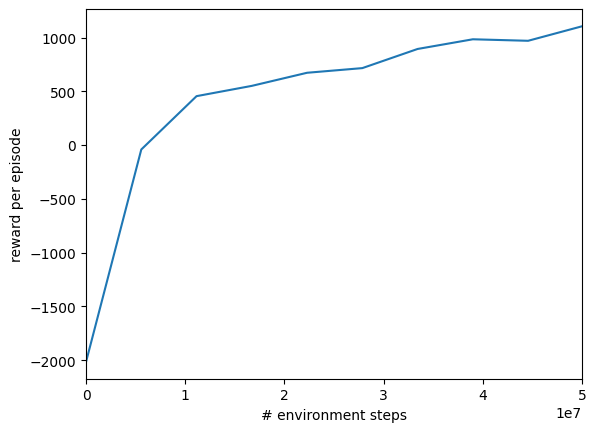

time to jit: 0:00:46.697480
time to train: 0:04:18.158243


In [7]:
#@title Training

train_fn = functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=4096, batch_size=2048, seed=1)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [8]:
model.save_params('/content/params', params)
params = model.load_params('/content/params')
inference_fn = make_inference_fn(params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [9]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
actions = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)
  actions.append(act.tolist())

HTML(html.render(env.sys.replace(dt=env.dt), rollout))

In [10]:
import json
out = {
    "pos": [],
    "rot": [],
}

for s in rollout:
    out["pos"].append(s.x.pos.tolist())
    out["rot"].append(s.x.rot.tolist())

open("out.json", "w").write(json.dumps(out, indent=4))

4105031

🙌 See you soon!